## $\mathbf{\text{Ecuación de Stokes:}}$

La formulación fuerte del problema de Stokes se escribe como sigue:
$$\mu\Delta\mathbf{u}-\nabla p=\mathbf{f}$$
$$\nabla\cdot\mathbf{u} = 0$$
$$\mathbf{u}=\mathbf{u}_D\,\,\,\text{ en }\partial\Omega$$
donde $\mathbf{u}$ es el campo de velocidad, $p$ es la presión, $\mu$ es la viscosidad dinámica, $\mathbf{f}$ es la fuerza externa aplicada, y $\mathbf{u}_D$ representa las condiciones de contorno en la frontera $\partial\Omega$.

### $\mathbf{\text{Formulación Variacional:}}$

Encontrar $\mathbf{u} \in \mathcal{V}= H_D^1(\Omega)^d$ y $p \in Q=L^2_{\int=0}(\Omega)$ tales que:
$$\mu\int_\Omega \nabla\mathbf{u}:\nabla\mathbf{v}-\int_\Omega p\nabla\cdot\mathbf{v}=\int_\Omega\mathbf{f}\cdot\mathbf{v}$$
$$\int_\Omega q\nabla\cdot\mathbf{u}=0$$


In [2]:
# Las librearias que usaremos

from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
import numpy as np

### $\text{Pares inf-sup estables}$:

Primero comenzamos definiendo la función que automatize el solver de Stokes.

In [3]:
# Las entradas de la función serán la malla, la viscosidad, la fuerza externa, el orden de los polinomios y la solución manufacturada
# en velocidad 
def SolveStokes(mesh,mu,ff,k,uSol):
    V = VectorH1(mesh,order=k+1, dirichlet="left|right|bottom|top") # Almendra (Taylor-Hood)
    Q = H1(mesh,order=k)  # Almedra (Taylor-Hood)
    
    #V = 
    #Q = H1(mesh,order=k) # Juanpi (Mini element)

    X = V*Q

    u,p = X.TrialFunction()  # Funciones Trial
    v,q = X.TestFunction()  # Funciones Test
    
    Stokes = (mu*InnerProduct(grad(u),grad(v)) + grad(p)*v + q*div(u))  # Escribimos el problema variacional completa simbolicamente

    a = BilinearForm(X)  # Creamos una forma bilineal
    a += Stokes*dx  # Agregamos el problema variacional a la forma bilineal
    a.Assemble()   # Ensamblamos la forma bilineal
    
    f = LinearForm(X)   # Creamos una forma lineal
    f += SymbolicLFI(ff*v)   # Agregamos la fuerza externa a la forma lineal a traves de un integrador simbolico
    f.Assemble()   # Ensamblamos la forma lineal
    
    gf = GridFunction(X)   # Creamos una función de malla en X=V*Q para almacenar la solución
    gf.components[0].Set(uSol, definedon=mesh.Boundaries("left|right|bottom|top"))  # Condiciones de Dirichlet para la velocidad
    
    res = f.vec - a.mat*gf.vec  # Calculamos el residuo de la solución inicial
    inv_stokes = a.mat.Inverse(X.FreeDofs())  # Calculamos la inversa de la matriz del sistema de Stokes para los grados de libertad libres
    gf.vec.data += inv_stokes * res   # Actualizamos la solución con el residuo corregido

    return gf  # Esto devuelve el par ordenado (velocidad, presión)

Para calcular las curvas de convergencia, usaremos una solución manufacturada polinomial: $\mathbf{u}=(u_1,u_2)$ con $u_1(x,y)=x(1-x)y(1-y)$ y $u_2(x,y)=(2x-1)y^2(\frac{1}{2}-\frac{y}{3})$, y $p=x^2y^2-\frac{1}{9}$. El vector de fuerza $\mathbf{f}$ se deriva de reemplazar la solución en la ecuación continua de Stokes y $\mathbf{u}_D$ coincide con la solución en la frontera.

In [52]:
# Ahora resolvemos recursivamente el problema de Stokes mediante un refinamiento uniforme de la malla.

# Comenzamos creando la malla inicial, que es un cuadrado unitario.
square = Rectangle(1.0, 1.0).Face()
    
# Nombra la cara (el dominio interno)
square.faces.name = "domain"
    
# Nombra los bordes
square.edges.name = "default"
square.edges.Min(X).name = "left"
square.edges.Max(X).name = "right"
square.edges.Min(Y).name = "bottom"
square.edges.Max(Y).name = "top"

geo = OCCGeometry(square, dim=2)
mesh = Mesh(geo.GenerateMesh(maxh=0.5))
mesh.Curve(3)

# Datos del problema

mu = 1.0   # Viscosidad
usol = CF((x*(1-x)*y*(1-y), (2*x-1)*(y**2)*(0.5-y/3)))   # Solución manufacturada para la velocidad
psol = x**2*y**2-1/9 # Solución manufacturada para la presión

comp1 = 2*y*(1 - y) + 2*x*(1 - x) + 2*x*y**2   
comp2 = -(2*x - 1)*(1 - 2*y) + 2*x**2*y

ff = CF((comp1, comp2))    # Fuerza externa calculada a partir de la solución manufacturada

grado = 2  # Usaremos P3/P2 (Taylor-Hood) 

ListaErroresU = []  # Lista para almacenar el número de elementos y el error en cada refinamiento para la velocidad
ListaErroresP = []  # Lista para almacenar el número de elementos y el error en cada refinamiento para la presión


while mesh.ne < 5000:
    
    up = SolveStokes(mesh,mu,ff,grado,usol)
    u = up.components[0]
    p = up.components[1]
    c = Integrate(p,mesh,VOL) 
    pp = p - c/Integrate(1,mesh,VOL)  # Corregimos la presión para que tenga media cero

    V = VectorH1(mesh, order = grado+1)
    uSol = GridFunction(V, name="uSol")
    uSol.Set(usol)
    
    ErrorU = sqrt(Integrate(InnerProduct(Grad(u-uSol),Grad(u-uSol)),mesh,VOL))   # Calculamos el error en la velocidad usando la norma H1
    ListaErroresU.append((mesh.ne,ErrorU))    # Listamos el número de elementos y el error para cada refinamiento

    P = H1(mesh, order = grado)
    pSol = GridFunction(P, name="pSol")
    pSol.Set(psol)  # La solución exacta de la presión es cero en este caso

    ErrorP = sqrt(Integrate((pp-pSol)*(pp-pSol),mesh,VOL))   # Calculamos el error en la presión usando la norma L2
    ListaErroresP.append((mesh.ne,ErrorP))    # Listamos el número de elementos y el error para cada refinamiento
    mesh.Refine()  # Refinamiento uniforme de la malla



Ahora graficamos los errores en funcion del numero de elementos. Para calcular la pendiente de convergencia debemos considerar que si $N$ es el numero de elementos de nuestro mallado, entonces
$$h\approx N^{-1/d}$$

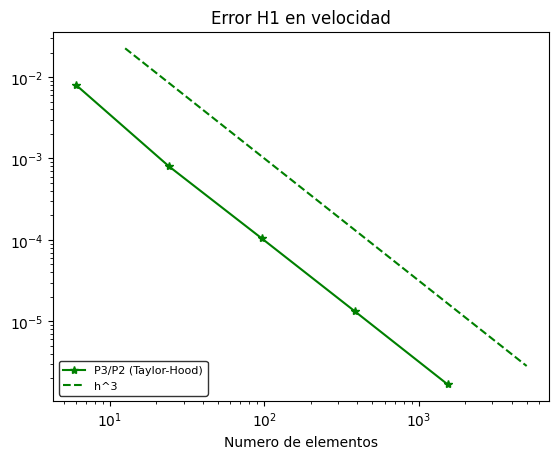

In [53]:
import matplotlib.pyplot as plt
import numpy as np

plt.yscale('log')
plt.xscale('log')
plt.xlabel("Numero de elementos")
plt.title("Error H1 en velocidad")
N1,err = zip(*ListaErroresU)
plt.plot(N1,err, label='P3/P2 (Taylor-Hood)', marker='*',color='green')

x1_func = np.linspace(0, 5000, 400) 
y1_func = 1 / x1_func**((grado+1)/2)
plt.plot(x1_func, y1_func, label='h^3', color='green', linestyle='--')

plt.ion()
plt.legend(
    loc='lower left',
    frameon=True,         # muestra borde del recuadro
    facecolor='white',    # color de fondo del recuadro
    edgecolor='black',    # color del borde
    fontsize=8           # tamaño de letra
)

plt.show()

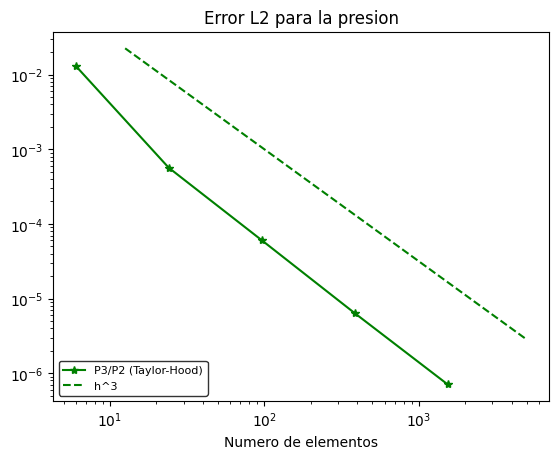

In [56]:
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Numero de elementos")
plt.title("Error L2 para la presion")
N1,err = zip(*ListaErroresP)
plt.plot(N1,err, label='P3/P2 (Taylor-Hood)', marker='*',color='green')

x1_func = np.linspace(0, 5000, 400) 
y1_func = 1 / x1_func**((grado+1)/2)
plt.plot(x1_func, y1_func, label='h^3', color='green', linestyle='--')

plt.ion()
plt.legend(
    loc='lower left',
    frameon=True,         # muestra borde del recuadro
    facecolor='white',    # color de fondo del recuadro
    edgecolor='black',    # color del borde
    fontsize=8           # tamaño de letra
)

plt.show()

### $\text{Stokes Estabilizado:}$

In [37]:
def SolveStokesPSPG(mesh,mu,ff,k,uSol):
    V = VectorH1(mesh,order=k, dirichlet="left|right|bottom|top") 
    Q = H1(mesh,order=k)  

    X = V*Q

    u,p = X.TrialFunction()  # Funciones Trial
    v,q = X.TestFunction()  # Funciones Test
    
    jump_p = p - p.Other()
    jump_q = q - q.Other()

    h = specialcf.mesh_size # Tamaño de la malla
    C1 = 1/2
    C0 = 1/12

    gamma_E = C1*h/mu
    delta_K = C0*h**2/mu

    Stokes = (mu*InnerProduct(grad(u),grad(v))*dx + grad(p)*v*dx + q*div(u)*dx+gamma_E*jump_p*jump_q/h*ds(skeleton=True)
              +InnerProduct(grad(p),delta_K*grad(q))*dx ) # Escribimos el problema variacional completa simbolicamente

    a = BilinearForm(X)
    a += Stokes  # Agregamos el problema variacional a la forma bilineal
    a.Assemble()   # Ensamblamos la forma bilineal
    
    f = LinearForm(X)   # Creamos una forma lineal
    f += SymbolicLFI(ff*v+delta_K*ff*grad(q))   # Agregamos la fuerza externa a la forma lineal a traves de un integrador simbolico
    f.Assemble()   # Ensamblamos la forma lineal
    
    gf = GridFunction(X)   # Creamos una función de malla en X=V*Q para almacenar la solución
    gf.components[0].Set(uSol, definedon=mesh.Boundaries("left|right|bottom|top"))  # Condiciones de Dirichlet para la velocidad
    
    res = f.vec - a.mat*gf.vec  # Calculamos el residuo de la solución inicial
    inv_stokes = a.mat.Inverse(X.FreeDofs())  # Calculamos la inversa de la matriz del sistema de Stokes para los grados de libertad libres
    gf.vec.data += inv_stokes * res   # Actualizamos la solución con el residuo corregido

    return gf  # Esto devuelve el par ordenado (velocidad, presión)

In [51]:
# Ahora resolvemos recursivamente el problema de Stokes mediante un refinamiento uniforme de la malla.

# Comenzamos creando la malla inicial, que es un cuadrado unitario.
square = Rectangle(1.0, 1.0).Face()
    
# Nombra la cara (el dominio interno)
square.faces.name = "domain"
    
# Nombra los bordes
square.edges.name = "default"
square.edges.Min(X).name = "left"
square.edges.Max(X).name = "right"
square.edges.Min(Y).name = "bottom"
square.edges.Max(Y).name = "top"

geo = OCCGeometry(square, dim=2)
mesh = Mesh(geo.GenerateMesh(maxh=0.5))
mesh.Curve(3)

# Datos del problema

mu = 1.0   # Viscosidad
usol = CF((x*(1-x)*y*(1-y), (2*x-1)*(y**2)*(0.5-y/3)))   # Solución manufacturada para la velocidad
psol = x**2*y**2-1/9 # Solución manufacturada para la presión

comp1 = 2*y*(1 - y) + 2*x*(1 - x) + 2*x*y**2   
comp2 = -(2*x - 1)*(1 - 2*y) + 2*x**2*y

ff = CF((comp1, comp2))    # Fuerza externa calculada a partir de la solución manufacturada

grado = 2  # Usaremos P3/P2 (Taylor-Hood) 

ListaErroresU = []  # Lista para almacenar el número de elementos y el error en cada refinamiento para la velocidad
ListaErroresP = []  # Lista para almacenar el número de elementos y el error en cada refinamiento para la presión


while mesh.ne < 5000:
    
    up = SolveStokesPSPG(mesh,mu,ff,grado,usol)
    u = up.components[0]
    p = up.components[1]

    V = VectorH1(mesh, order = grado+1)
    uSol = GridFunction(V, name="uSol")
    uSol.Set(usol)
    
    ErrorU = sqrt(Integrate(InnerProduct(Grad(u-uSol),Grad(u-uSol)),mesh,VOL))   # Calculamos el error en la velocidad usando la norma H1
    ListaErroresU.append((mesh.ne,ErrorU))    # Listamos el número de elementos y el error para cada refinamiento

    P = H1(mesh, order = 6)
    pSol = GridFunction(P, name="pSol")
    pSol.Set(psol)  # La solución exacta de la presión es cero en este caso

    ErrorP = sqrt(Integrate((p-pSol)*(p-pSol),mesh,VOL))   # Calculamos el error en la presión usando la norma L2
    ListaErroresP.append((mesh.ne,ErrorP))    # Listamos el número de elementos y el error para cada refinamiento
    mesh.Refine()  # Refinamiento uniforme de la malla


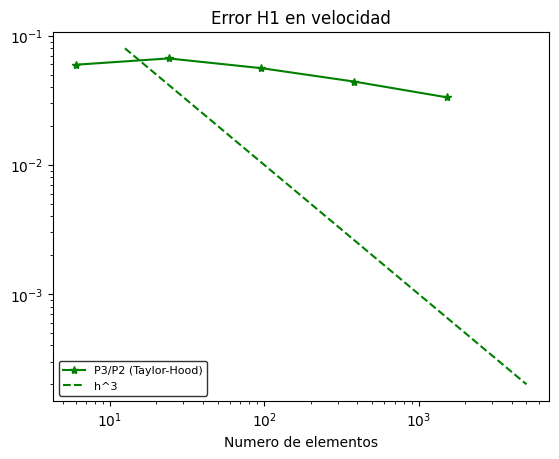

In [44]:
import matplotlib.pyplot as plt
import numpy as np

plt.yscale('log')
plt.xscale('log')
plt.xlabel("Numero de elementos")
plt.title("Error H1 en velocidad")
N1,err = zip(*ListaErroresU)
plt.plot(N1,err, label='P3/P2 (Taylor-Hood)', marker='*',color='green')

x1_func = np.linspace(0, 5000, 400) 
y1_func = 1 / x1_func**((grado)/2)
plt.plot(x1_func, y1_func, label='h^3', color='green', linestyle='--')

plt.ion()
plt.legend(
    loc='lower left',
    frameon=True,         # muestra borde del recuadro
    facecolor='white',    # color de fondo del recuadro
    edgecolor='black',    # color del borde
    fontsize=8           # tamaño de letra
)

plt.show()